# Examen Mercados Eléctricos 2024

Considere el sistema de alimentación de dos barras mostrado en la Figura. Los costos marginales de producción de los generadores conectados a las barras A y B vienen dado respectivamente por las siguientes expresiones:

### Paquetes

In [4]:
using DataFrames

### Ingreso de Número de Cédula de Identidad

In [5]:
RUN = 23000775

23000775

### Definición de Parametros de los Costos Marginales

In [6]:
using LaTeXStrings, Latexify, Symbolics
function separar_digitos(numero::Int)
    # Convertir el número a cadena de caracteres
    cadena = string(numero)
    
    # Convertir cada carácter en un número entero y almacenarlo en una lista
    digitos = [parse(Int, c) for c in cadena]
    
    return digitos
end

VCI = separar_digitos(RUN)
a0 = VCI[3]*10+VCI[4]
a1 = VCI[length(VCI)]/100


println("El costo marginal del Generador A es $a0+$a1*P_A [USD/MWh]")

b0 = VCI[1]*10+VCI[2]
b1 = VCI[length(VCI)-1]/100
printstyled("El costo marginal del Generador B es $b0+$b1*P_B [USD/MWh]")



El costo marginal del Generador A es 0+0.05*P_A [USD/MWh]
El costo marginal del Generador B es 23+0.07*P_B [USD/MWh]

### Definición de Parametros del problema

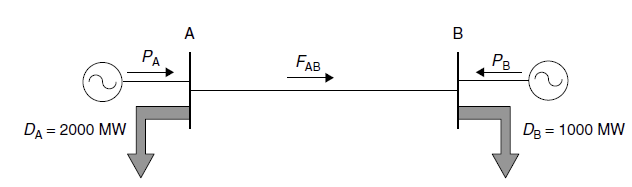

In [7]:
Buses = ["A"; "B"]

2-element Vector{String}:
 "A"
 "B"

In [8]:
generators = DataFrame(
    name=[Buses; "GF1"; "GF2"],
    capacity= [99999, 99999, 99999, 99999],
)

Row,name,capacity
,String,Int64
1,A,99999
2,B,99999
3,GF1,99999
4,GF2,99999


In [9]:
branches = DataFrame(name=["AB"], capacity=[999999], reactance=[0])

Row,name,capacity,reactance
,String,Int64,Int64
1,AB,999999,0


In [10]:
demand = DataFrame(
    bus=Buses,
    value=[2000, 1000],
)


Row,bus,value
,String,Int64
1,A,2000
2,B,1000


## Selección de Casos

In [11]:
Caso = 5

5

## Casos

In [12]:
if Caso == 1
# Caso 1
branches.capacity[1] = 0
generators.capacity[1]= 999999
generators.capacity[2]= 999999
elseif Caso == 2
# #Caso 2
branches.capacity[1] = 999999
elseif Caso==3
# #Caso 3
generators.capacity[2]= VCI[1]*1000+VCI[2]*100+VCI[3]*10+VCI[4]
elseif Caso==4
# #Caso 4
generators.capacity[1]= VCI[length(VCI)-2]*100+VCI[length(VCI)-1]*10+VCI[length(VCI)]
generators.capacity[2]= 999999
elseif Caso==5
# #Caso 5
generators.capacity[2]= VCI[1]*1000+VCI[2]*100+VCI[3]*10+VCI[4]
generators.capacity[1]= VCI[length(VCI)-2]*100+VCI[length(VCI)-1]*10+VCI[length(VCI)]
branches.capacity[1]= VCI[1]*100+VCI[2]*10+VCI[3]
end
println(generators.capacity)

[775, 2300, 99999, 99999]


## Formulación de optimización

In [13]:
using JuMP
using HiGHS

# Crear el modelo de optimización
model = Model(HiGHS.Optimizer)

# Variables de generación
@variable(model, 0 <= gen[g in generators.name] <= generators.capacity[findfirst(x -> x == g, generators.name)])

# Variables de flujo de potencia en las ramas
@variable(model, -branches.capacity[findfirst(x -> x == b, branches.name)]<= branch_flow[b in branches.name] <= branches.capacity[findfirst(x -> x == b, branches.name)])


1-dimensional DenseAxisArray{VariableRef,1,...} with index sets:
    Dimension 1, ["AB"]
And data, a 1-element Vector{VariableRef}:
 branch_flow[AB]

### Restricciones de Balance

In [14]:
balance = Dict()
balance["A"] = @constraint(model, gen["A"]-branch_flow["AB"]+gen["GF1"]== demand.value[findfirst(x->x=="A",demand.bus)])
balance["B"] = @constraint(model, gen["B"]+branch_flow["AB"]+gen["GF2"] == demand.value[findfirst(x->x=="B",demand.bus)])
print(model)

Feasibility
Subject to
 gen[A] + gen[GF1] - branch_flow[AB] == 2000
 gen[B] + gen[GF2] + branch_flow[AB] == 1000
 gen[A] >= 0
 gen[B] >= 0
 gen[GF1] >= 0
 gen[GF2] >= 0
 branch_flow[AB] >= -230
 gen[A] <= 775
 gen[B] <= 2300
 gen[GF1] <= 99999
 gen[GF2] <= 99999
 branch_flow[AB] <= 230


### Optimización

In [15]:
function CT(A0, A1, PA) #Función de computo de costo total
    A0*PA + 0.5*A1*PA^2
end
VOLL=5000
@objective(model, Min, CT(a0,a1,gen["A"])+CT(b0,b1,gen["B"])+VOLL*gen["GF1"]+VOLL*gen["GF2"])


0.025 gen[A]² + 0.035 gen[B]² + 23 gen[B] + 5000 gen[GF1] + 5000 gen[GF2]

In [16]:
optimize!(model)
has_duals(model)
function CM(A0, A1, PA)
    A0+A1*PA
end


Running HiGHS 1.7.0 (git hash: 50670fd4c): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [2e+01, 5e+03]
  Bound  [2e+02, 1e+05]
  RHS    [1e+03, 2e+03]
Iteration, Runtime, ObjVal, NullspaceDim
0, 0.013104, 8931241.734935, 0
2, 0.013154, 5071257.282822, 0
Model   status      : Optimal
Objective value     :  5.0712571250e+06
HiGHS run time      :          0.01


CM (generic function with 1 method)

In [17]:
using LaTeXStrings, Latexify, Symbolics

## Modelo

In [18]:
print(model)

Min 0.025 gen[A]² + 0.035 gen[B]² + 23 gen[B] + 5000 gen[GF1] + 5000 gen[GF2]
Subject to
 gen[A] + gen[GF1] - branch_flow[AB] == 2000
 gen[B] + gen[GF2] + branch_flow[AB] == 1000
 gen[A] >= 0
 gen[B] >= 0
 gen[GF1] >= 0
 gen[GF2] >= 0
 branch_flow[AB] >= -230
 gen[A] <= 775
 gen[B] <= 2300
 gen[GF1] <= 99999
 gen[GF2] <= 99999
 branch_flow[AB] <= 230


## Results

### Power

In [19]:
for g in generators.name
    println("Generator $g: ", value(gen[g]), " MW")
    end

Generator A: 775.0 MW
Generator B: 1230.0 MW
Generator GF1: 995.0 MW
Generator GF2: 0.0 MW


### Branch Flow

In [20]:
println("Flow Branch A-B: ", value(branch_flow["AB"]), " MW")

Flow Branch A-B: -230.0 MW


### Nodal Prices

In [21]:
println("\nPrecios nodales:")
λ=DataFrame(PM=zeros(length(Buses)))
for node in Buses 
    λ.PM[findfirst(x-> x == node, Buses)]= dual(balance[node])
    println("Precio nodal en nodo $node: ", round(λ.PM[findfirst(x-> x == node, Buses)];digits=2), " USD/MWh") 
end



Precios nodales:
Precio nodal en nodo A: 5000.0 USD/MWh
Precio nodal en nodo B: 109.1 USD/MWh


### Ingresos Generadores & Pago de Demandas

In [22]:
FlujoDinero=DataFrame(IG=zeros(length(Buses)),PD=zeros(length(Buses)))

for gene in Buses
    FlujoDinero.IG[findfirst(x-> x == gene, Buses)]= round(value(gen[gene]* λ.PM[findfirst(x-> x == gene, Buses)]);digits=0)
    FlujoDinero.PD[findfirst(x-> x == gene, Buses)]= round(demand.value[findfirst(x-> x == gene, Buses)]* λ.PM[findfirst(x-> x == gene, Buses)];digits=0)
end
println(FlujoDinero)

2×2 DataFrame
 Row │ IG            PD         
     │ Float64       Float64    
─────┼──────────────────────────
   1 │      3.875e6       1.0e7
   2 │ 134193.0      109100.0


## Resultados Casos

In [23]:
Precios=DataFrame(c1=zeros(length(Buses)),
                c2=zeros(length(Buses)),
                c3=zeros(length(Buses)),
                c4=zeros(length(Buses)),
                c5=zeros(length(Buses)))
Generacion=DataFrame(c1=zeros(length(Buses)),
                c2=zeros(length(Buses)),
                c3=zeros(length(Buses)),
                c4=zeros(length(Buses)),
                c5=zeros(length(Buses)))
Flujos=DataFrame(c1=zeros(1),
                c2=zeros(1),
                c3=zeros(1),
                c4=zeros(1),
                c5=zeros(1))
FD=DataFrame(IG_c1=zeros(length(Buses)), PD_c1=zeros(length(Buses)),
            IG_c2=zeros(length(Buses)), PD_c2=zeros(length(Buses)),
            IG_c3=zeros(length(Buses)), PD_c3=zeros(length(Buses)),
            IG_c4=zeros(length(Buses)), PD_c4=zeros(length(Buses)),
            IG_c5=zeros(length(Buses)), PD_c5=zeros(length(Buses)))

function modelo(branches, generators)
    # Crear el modelo de optimización
    modeln = Model(HiGHS.Optimizer)
    # Variables de generación
    @variable(modeln, 0 <= gen[g in generators.name] <= generators.capacity[findfirst(x -> x == g, generators.name)])
    # Variables de flujo de potencia en las ramas
    @variable(modeln, -branches.capacity[findfirst(x -> x == b, branches.name)]<= branch_flow[b in branches.name] <= branches.capacity[findfirst(x -> x == b, branches.name)])
    balancen = Dict()
    balancen["A"] = @constraint(modeln, gen["A"]+gen["GF1"]-branch_flow["AB"] == demand.value[findfirst(x->x=="A",demand.bus)])
    balancen["B"] = @constraint(modeln, gen["B"]+gen["GF2"]+branch_flow["AB"] == demand.value[findfirst(x->x=="B",demand.bus)])

    function CT1(A0, A1, PA) #Función de computo de costo total
      A0*PA + 0.5*A1*PA^2
    end

    @objective(modeln, Min, CT(a0,a1,gen["A"])+CT(b0,b1,gen["B"])+(VOLL*gen["GF1"]+VOLL*gen["GF2"]))
    optimize!(modeln)
    return modeln, gen, balancen, demand, branch_flow
end

for Case in [1,2,3,4,5]
    if Case == 1
    # Caso 1
        branches.capacity[1] = 0
        generators.capacity[1]= 999999
        generators.capacity[2]= 999999
        ## simulación
        model1, gen, balance1, demand, branch_flow = modelo(branches, generators)
        for nodes in Buses
            Precios.c1[findfirst(x-> x == nodes, Buses)]= dual(balance1[nodes])
            Generacion.c1[findfirst(x-> x == nodes, Buses)] = value(gen[nodes])       
            FD.IG_c1[findfirst(x-> x == nodes, Buses)]= 
            round(value(gen[nodes]* Precios.c1[findfirst(x-> x == nodes, Buses)]);digits=0)
            FD.PD_c1[findfirst(x-> x == nodes, Buses)]= 
            round(demand.value[findfirst(x-> x == nodes, Buses)]* Precios.c1[findfirst(x-> x == nodes, Buses)];digits=0)
        end
        Flujos.c1[1]=value(branch_flow["AB"])
    elseif Case == 2
    # Caso 2
        branches.capacity[1] = 999999
        ## simulación
        model2, gen, balance2, demand, branch_flow = modelo(branches, generators)
        for nodes in Buses
            Precios.c2[findfirst(x-> x == nodes, Buses)]= dual(balance2[nodes])
            Generacion.c2[findfirst(x-> x == nodes, Buses)] = value(gen[nodes])       
            FD.IG_c2[findfirst(x-> x == nodes, Buses)]= 
            round(value(gen[nodes]* Precios.c2[findfirst(x-> x == nodes, Buses)]);digits=0)
            FD.PD_c2[findfirst(x-> x == nodes, Buses)]= 
            round(demand.value[findfirst(x-> x == nodes, Buses)]* Precios.c2[findfirst(x-> x == nodes, Buses)];digits=0)
        end
        Flujos.c2[1]=value(branch_flow["AB"])
    elseif Case==3
    # # #Caso 3
        generators.capacity[2]= VCI[1]*1000+VCI[2]*100+VCI[3]*10+VCI[4]
         ## simulación
         model3, gen, balance3, demand, branch_flow = modelo(branches, generators)
         for nodes in Buses
             Precios.c3[findfirst(x-> x == nodes, Buses)]= dual(balance3[nodes])
             Generacion.c3[findfirst(x-> x == nodes, Buses)] = value(gen[nodes])       
             FD.IG_c3[findfirst(x-> x == nodes, Buses)]= 
             round(value(gen[nodes]* Precios.c3[findfirst(x-> x == nodes, Buses)]);digits=0)
             FD.PD_c3[findfirst(x-> x == nodes, Buses)]= 
             round(demand.value[findfirst(x-> x == nodes, Buses)]* Precios.c3[findfirst(x-> x == nodes, Buses)];digits=0)
         end
         Flujos.c3[1]=value(branch_flow["AB"])
    elseif Case==4
    # # #Caso 4 
        generators.capacity[1]= VCI[length(VCI)-2]*100+VCI[length(VCI)-1]*10+VCI[length(VCI)]
        generators.capacity[2]= 999999
        ## simulación
        model4, gen, balance4, demand, branch_flow = modelo(branches, generators)
        for nodes in Buses
            Precios.c4[findfirst(x-> x == nodes, Buses)]= dual(balance4[nodes])
            Generacion.c4[findfirst(x-> x == nodes, Buses)] = value(gen[nodes])       
            FD.IG_c4[findfirst(x-> x == nodes, Buses)]= 
            round(value(gen[nodes]* Precios.c4[findfirst(x-> x == nodes, Buses)]);digits=0)
            FD.PD_c4[findfirst(x-> x == nodes, Buses)]= 
            round(demand.value[findfirst(x-> x == nodes, Buses)]* Precios.c4[findfirst(x-> x == nodes, Buses)];digits=0)
        end
        Flujos.c4[1]=value(branch_flow["AB"])
    elseif Case==5
    # Caso 5
        #generators.capacity[1]= 999999
        #generators.capacity[2]= 999999
        generators.capacity[2]= VCI[1]*1000+VCI[2]*100+VCI[3]*10+VCI[4]
        branches.capacity[1]= VCI[1]*100+VCI[2]*10+VCI[3]
        model5, gen, balance5, demand, branch_flow = modelo(branches, generators)
        println(model5)
        for nodes in Buses
            Precios.c5[findfirst(x-> x == nodes, Buses)]= dual(balance5[nodes])
            Generacion.c5[findfirst(x-> x == nodes, Buses)] = value(gen[nodes])       
            FD.IG_c5[findfirst(x-> x == nodes, Buses)]= 
            round(value(gen[nodes]* Precios.c5[findfirst(x-> x == nodes, Buses)]);digits=0)
            FD.PD_c5[findfirst(x-> x == nodes, Buses)]= 
            round(demand.value[findfirst(x-> x == nodes, Buses)]* Precios.c5[findfirst(x-> x == nodes, Buses)];digits=0)
        end
        Flujos.c5[1]=value(branch_flow["AB"])
        
    end
end
printstyled(Precios)
printstyled(Generacion)
printstyled(FD)
printstyled(Flujos)

Running HiGHS 1.7.0 (git hash: 50670fd4c): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [2e+01, 5e+03]
  Bound  [1e+05, 1e+06]
  RHS    [1e+03, 2e+03]
Iteration, Runtime, ObjVal, NullspaceDim
0, 0.000233, 158000.250000, 0
1, 0.000242, 158000.250000, 0
Model   status      : Optimal
Objective value     :  1.5800000000e+05
HiGHS run time      :          0.00
Running HiGHS 1.7.0 (git hash: 50670fd4c): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [2e+01, 5e+03]
  Bound  [1e+05, 1e+06]
  RHS    [1e+03, 2e+03]
Iteration, Runtime, ObjVal, NullspaceDim
0, 0.000297, 225000.500000, 0
3, 0.000328, 157796.078010, 1
Model   status      : Optimal
Objective value     :  1.5779583333e+05
HiGHS run time      :          0.00
Running HiGHS 1.7.0 (git hash: 50670fd4c): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [2e+01, 5e+03]
  Bound  [